In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.layers import Flatten, Dense
from keras.models import Model
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [2]:
train_path = "path to/Celebrity Faces Dataset"
folders = sorted(os.listdir(train_path), reverse=False)

In [3]:
###facial recognition preprocessing

In [4]:
def preprocess_image(img, target_size=(224, 224)):
    if isinstance(img, str):
        img = image.load_img(img, target_size=target_size)
    else:
        img = cv2.resize(img, target_size)
        img = image.array_to_img(img)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [5]:
def preprocess_image2(img, target_size=(224, 224), apply_histogram_equalization=True):
    if isinstance(img, str):
        img = image.load_img(img, target_size=target_size)
    else:
        img = cv2.resize(img, target_size)
        img = image.array_to_img(img)

    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  

    if apply_histogram_equalization:
        img_array = histogram_equalization(img_array)


    img_array = np.repeat(img_array, 3, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [6]:
def histogram_equalization(img_array):
    img_uint8 = (img_array.squeeze() * 255).astype(np.uint8)
    img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
    img_equalized = cv2.equalizeHist(img_gray)
    img_equalized = img_equalized / 255.0
    return np.expand_dims(img_equalized, axis=-1)

In [7]:
prototxt_path = 'path to/deploy.prototxt'
caffemodel_path = 'path to/res10_300x300_ssd_iter_140000_fp16.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

In [8]:
def detect_faces_and_crop(image_path):
    img = cv2.imread(image_path)
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    faces = net.forward()
    max_confidence = 0
    best_face = None
    for i in range(faces.shape[2]):
        confidence = faces[0, 0, i, 2]
        if confidence > max_confidence:
            max_confidence = confidence
            box = faces[0, 0, i, 3:7] * np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
            face_roi = img[startY:endY, startX:endX]
            face_roi = cv2.resize(face_roi, IMAGE_SIZE)
            best_face = face_roi
    return best_face

In [9]:
def detect_faces_and_predict(cropped_face):
    face_array = preprocess_image(cropped_face, target_size=IMAGE_SIZE)
    predictions = model.predict(face_array)
    for j, prob in enumerate(predictions[0]):
        print(f"Probability for {folders[j]}: {prob}")
    predicted_class_index = np.argmax(predictions)
    celebrity_name = folders[predicted_class_index]
    return celebrity_name, predictions[0][predicted_class_index]

In [10]:
def detect_faces_and_predict_ensemble(cropped_face):
    face_array1 = preprocess_image(cropped_face, target_size=IMAGE_SIZE)
    face_array2 = preprocess_image2(cropped_face, target_size=IMAGE_SIZE)
    predictions1 = model.predict(face_array1)
    predictions2 = model.predict(face_array2)
    ensemble_probabilities = (predictions1 + predictions2) / 2.0

    for j, prob in enumerate(ensemble_probabilities[0]):
        print(f"Ensemble Probability for {folders[j]}: {prob}")

    predicted_class_index = np.argmax(ensemble_probabilities)
    celebrity_name = folders[predicted_class_index]
    return celebrity_name, ensemble_probabilities[0][predicted_class_index]

In [11]:
IMAGE_SIZE = (224, 224) 
def display_results(image_path, prediction, processed_face):
    img = cv2.imread(image_path)
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    faces = net.forward()
    
    max_confidence = 0
    best_face = None
    for i in range(faces.shape[2]):
        confidence = faces[0, 0, i, 2]
        if confidence > max_confidence:
            max_confidence = confidence
            box = faces[0, 0, i, 3:7] * np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
            best_face = img[startY:endY, startX:endX]

    plt.figure(facecolor='white',figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(processed_face, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Label: {prediction[0]}, Probability: {prediction[1]:.3f}", fontsize=12)
    plt.axis('on')
    plt.xticks([]), plt.yticks([]) 

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image", fontsize=12)
    plt.axis('on')
    plt.xticks([]), plt.yticks([])  
    plt.subplot(1, 3, 3)
    cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Bounding Box", fontsize=12)
    plt.axis('on')
    plt.xticks([]), plt.yticks([])  
    plt.subplots_adjust(wspace=0.5)
    plt.show()

In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
model = load_model('combo_aug_model2.h5')
e_model = load_model("emotion_model.h5")
img_path = "path to/bp_happy.jpg"

In [13]:
###Facial Recognition No Ensemble

Probability for Angelina Jolie: 2.4544888788113894e-08
Probability for Brad Pitt: 0.8640161156654358
Probability for Denzel Washington: 1.0933487004649578e-07
Probability for Hugh Jackman: 0.0008139822748489678
Probability for Jennifer Lawrence: 0.001308286446146667
Probability for Johnny Depp: 1.8641623682924546e-05
Probability for Kate Winslet: 0.01193399541079998
Probability for Leonardo DiCaprio: 0.00012854000669904053
Probability for Megan Fox: 2.067255763904541e-06
Probability for Natalie Portman: 3.60804951924365e-05
Probability for Nicole Kidman: 0.041085414588451385
Probability for Robert Downey Jr: 1.5454158983629895e-06
Probability for Sandra Bullock: 0.00494925444945693
Probability for Scarlett Johansson: 0.0017999312840402126
Probability for Tom Cruise: 0.07390566170215607
Probability for Tom Hanks: 4.50905560001047e-07
Probability for Will Smith: 3.1795508448340115e-08


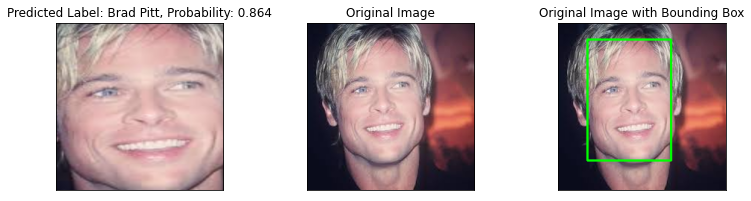

In [14]:
test_image_path = "path to/bp_happy.jpg"
cropped_faces_test = detect_faces_and_crop(img_path)
predictions_test = detect_faces_and_predict(cropped_faces_test)
display_results(test_image_path, predictions_test, cropped_faces_test)

In [15]:
###Facial Recognition Ensemble

Ensemble Probability for Angelina Jolie: 2.900133644345715e-08
Ensemble Probability for Brad Pitt: 0.9294126033782959
Ensemble Probability for Denzel Washington: 3.2800303415569942e-06
Ensemble Probability for Hugh Jackman: 0.000445653626229614
Ensemble Probability for Jennifer Lawrence: 0.0006580088520422578
Ensemble Probability for Johnny Depp: 4.986462226952426e-05
Ensemble Probability for Kate Winslet: 0.005982476752251387
Ensemble Probability for Leonardo DiCaprio: 0.0008677786099724472
Ensemble Probability for Megan Fox: 1.0464652859809576e-06
Ensemble Probability for Natalie Portman: 1.81660579983145e-05
Ensemble Probability for Nicole Kidman: 0.020546140149235725
Ensemble Probability for Robert Downey Jr: 5.745773705712054e-06
Ensemble Probability for Sandra Bullock: 0.0024747189600020647
Ensemble Probability for Scarlett Johansson: 0.0009002809529192746
Ensemble Probability for Tom Cruise: 0.038305576890707016
Ensemble Probability for Tom Hanks: 1.1723124771378934e-05
Ensemble

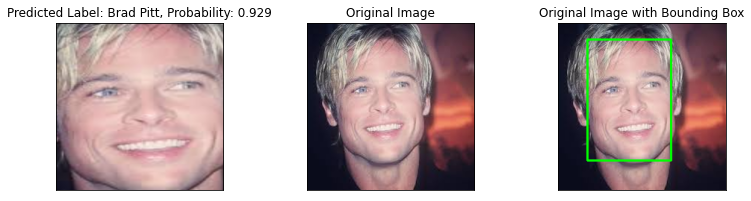

In [16]:
test_image_path = "path to/bp_happy.jpg"
cropped_faces_test = detect_faces_and_crop(img_path)
predictions_test = detect_faces_and_predict_ensemble(cropped_faces_test)
display_results(test_image_path, predictions_test, cropped_faces_test)

In [17]:
###Emotion Recognition

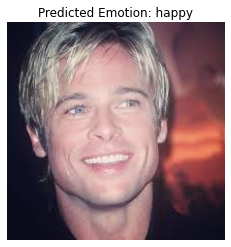

In [18]:
target_size = (48, 48)
img = image.load_img(img_path, target_size=target_size, color_mode="grayscale")
face_img = detect_faces_and_crop(img_path)
face_img = cv2.resize(face_img, target_size)
face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
img_array = image.img_to_array(face_img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0 

emotion_labels = e_model.predict(img_array)
predicted_emotion_index = np.argmax(emotion_labels)
emotion_labels_list = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]
predicted_emotion_label = emotion_labels_list[predicted_emotion_index]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_emotion_label}")
plt.axis('off')
plt.show()